In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time
from scipy.special import gamma

In [2]:
def simulate_cpu(N):
    # Simulation parameters
    t     = 0     # initial time
    tEnd  = 12    # end time
    dt    = 0.04  # timestep
    M     = 2     # star mass
    R     = 0.75  # star radius
    h     = 0.1   # smoothing length
    k     = 0.1   # equation of state constant
    n     = 1     # polytropic index
    nu    = 1     # damping factor

    np.random.seed(42)
    lmbda = 2*k*(1+n)*np.pi**(-3/(2*n)) * (M*gamma(5/2+n)/R**3/gamma(1+n))**(1/n) / R**2
    m     = M / N
    pos   = np.random.randn(N, 3)
    vel   = np.zeros((N, 3))

    def W(x, y, z, h):
        r = np.sqrt(x**2 + y**2 + z**2)
        return (1.0/(h*np.sqrt(np.pi)))**3 * np.exp(-r**2/h**2)

    def gradW(x, y, z, h):
        r = np.sqrt(x**2 + y**2 + z**2)
        n_val = -2 * np.exp(-r**2/h**2) / (h**5 * (np.pi)**(3/2))
        return n_val*x, n_val*y, n_val*z

    def getPairwiseSeparations(ri, rj):
        M_local = ri.shape[0]
        N_local = rj.shape[0]
        rix = ri[:,0].reshape((M_local, 1))
        riy = ri[:,1].reshape((M_local, 1))
        riz = ri[:,2].reshape((M_local, 1))
        rjx = rj[:,0].reshape((N_local, 1))
        rjy = rj[:,1].reshape((N_local, 1))
        rjz = rj[:,2].reshape((N_local, 1))
        dx = rix - rjx.T
        dy = riy - rjy.T
        dz = riz - rjz.T
        return dx, dy, dz

    def getDensity(r, pos, m, h):
        dx, dy, dz = getPairwiseSeparations(r, pos)
        rho = np.sum(m * W(dx, dy, dz, h), axis=1).reshape((-1, 1))
        return rho

    def getPressure(rho, k, n):
        return k * rho**(1+1/n)

    def getAcc(pos, vel, m, h, k, n, lmbda, nu):
        rho = getDensity(pos, pos, m, h)
        P   = getPressure(rho, k, n)
        dx, dy, dz = getPairwiseSeparations(pos, pos)
        dWx, dWy, dWz = gradW(dx, dy, dz, h)
        ax = - np.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWx, axis=1).reshape((-1, 1))
        ay = - np.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWy, axis=1).reshape((-1, 1))
        az = - np.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWz, axis=1).reshape((-1, 1))
        a = np.hstack((ax, ay, az))
        a -= lmbda * pos
        a -= nu * vel
        return a

    acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)
    Nt  = int(np.ceil(tEnd/dt))

    for i in range(Nt):
        # (1/2) kick
        vel += acc * dt/2
        # drift
        pos += vel * dt
        # update acceleration
        acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)
        # (1/2) kick
        vel += acc * dt/2
        t += dt

    return pos, vel

def simulate_gpu(N):
    # Simulation parameters
    t     = 0     # initial time
    tEnd  = 12    # end time
    dt    = 0.04  # timestep
    M     = 2     # star mass
    R     = 0.75  # star radius
    h     = 0.1   # smoothing length
    k     = 0.1   # equation of state constant
    n     = 1     # polytropic index
    nu    = 1     # damping factor

    cp.random.seed(42)
    lmbda = 2*k*(1+n)*cp.pi**(-3/(2*n)) * (M*gamma(5/2+n)/R**3/gamma(1+n))**(1/n) / R**2
    m     = M / N
    pos   = cp.random.randn(N, 3)
    vel   = cp.zeros((N, 3))

    def W(x, y, z, h):
        r = cp.sqrt(x**2 + y**2 + z**2)
        return (1.0/(h*cp.sqrt(cp.pi)))**3 * cp.exp(-r**2/h**2)

    def gradW(x, y, z, h):
        r = cp.sqrt(x**2 + y**2 + z**2)
        n_val = -2 * cp.exp(-r**2/h**2) / (h**5 * (cp.pi)**(3/2))
        return n_val*x, n_val*y, n_val*z

    def getPairwiseSeparations(ri, rj):
        M_local = ri.shape[0]
        N_local = rj.shape[0]
        rix = ri[:,0].reshape((M_local, 1))
        riy = ri[:,1].reshape((M_local, 1))
        riz = ri[:,2].reshape((M_local, 1))
        rjx = rj[:,0].reshape((N_local, 1))
        rjy = rj[:,1].reshape((N_local, 1))
        rjz = rj[:,2].reshape((N_local, 1))
        dx = rix - rjx.T
        dy = riy - rjy.T
        dz = riz - rjz.T
        return dx, dy, dz

    def getDensity(r, pos, m, h):
        dx, dy, dz = getPairwiseSeparations(r, pos)
        rho = cp.sum(m * W(dx, dy, dz, h), axis=1).reshape((-1, 1))
        return rho

    def getPressure(rho, k, n):
        return k * rho**(1+1/n)

    def getAcc(pos, vel, m, h, k, n, lmbda, nu):
        rho = getDensity(pos, pos, m, h)
        P   = getPressure(rho, k, n)
        dx, dy, dz = getPairwiseSeparations(pos, pos)
        dWx, dWy, dWz = gradW(dx, dy, dz, h)
        ax = - cp.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWx, axis=1).reshape((-1, 1))
        ay = - cp.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWy, axis=1).reshape((-1, 1))
        az = - cp.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWz, axis=1).reshape((-1, 1))
        a = cp.hstack((ax, ay, az))
        a -= lmbda * pos
        a -= nu * vel
        return a

    acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)
    Nt  = int(cp.ceil(tEnd/dt))

    for i in range(Nt):
        # (1/2) kick
        vel += acc * dt/2
        # drift
        pos += vel * dt
        # update acceleration
        acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)
        # (1/2) kick
        vel += acc * dt/2
        t += dt

    return pos, vel

N=400: CPU avg = 4.2807s (std: 2.9856s), GPU avg = 0.7730s (std: 0.0970s)
N=1000: CPU avg = 19.5551s (std: 0.9301s), GPU avg = 2.8848s (std: 0.0021s)
N=1600: CPU avg = 51.0206s (std: 0.0826s), GPU avg = 7.0465s (std: 0.0057s)
N=2200: CPU avg = 132.4672s (std: 0.1410s), GPU avg = 13.1018s (std: 0.0074s)


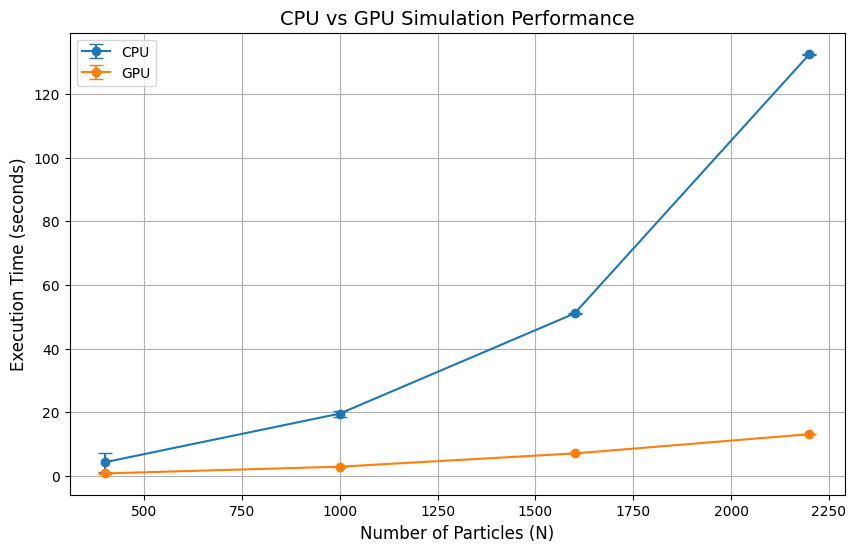

In [3]:
# define the range of particle counts and number of trials per configuration
particle_counts = [400, 1000, 1600, 2200]
num_trials = 5

cpu_avg_times = []
cpu_std_times = []
gpu_avg_times = []
gpu_std_times = []

for N_val in particle_counts:
    cpu_times = []
    gpu_times = []

    for trial in range(num_trials):
        # cpu
        start_cpu = time.perf_counter()
        simulate_cpu(N=N_val)
        end_cpu = time.perf_counter()
        cpu_times.append(end_cpu - start_cpu)

        # gpu
        start_gpu = time.perf_counter()
        simulate_gpu(N=N_val)
        cp.cuda.Device().synchronize()  # sync gpu
        end_gpu = time.perf_counter()
        gpu_times.append(end_gpu - start_gpu)

    cpu_avg = np.mean(cpu_times)
    cpu_std = np.std(cpu_times)
    gpu_avg = np.mean(gpu_times)
    gpu_std = np.std(gpu_times)

    cpu_avg_times.append(cpu_avg)
    cpu_std_times.append(cpu_std)
    gpu_avg_times.append(gpu_avg)
    gpu_std_times.append(gpu_std)

    print(f"N={N_val}: CPU avg = {cpu_avg:.4f}s (std: {cpu_std:.4f}s), GPU avg = {gpu_avg:.4f}s (std: {gpu_std:.4f}s)")

# plot performance results with error bars
plt.figure(figsize=(10,6))
plt.errorbar(particle_counts, cpu_avg_times, yerr=cpu_std_times, fmt='-o', capsize=5, label='CPU')
plt.errorbar(particle_counts, gpu_avg_times, yerr=gpu_std_times, fmt='-o', capsize=5, label='GPU')
plt.xlabel('Number of Particles (N)', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.title('CPU vs GPU Simulation Performance', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Comparing Functions

In [4]:
# total times for each function
time_data_cpu = {'W': 0, 'gradW': 0, 'getPairwiseSeparations': 0, 'getPressure': 0, 'getDensity': 0, 'getAcc': 0, 'other': 0}
time_data_gpu = {'W': 0, 'gradW': 0, 'getPairwiseSeparations': 0, 'getPressure': 0, 'getDensity': 0, 'getAcc': 0, 'other': 0}

# decorators
def time_cpu(label):
    def decorator(func):
        def wrapper(*args, **kwargs):
            t0 = time.perf_counter()
            out = func(*args, **kwargs)
            t1 = time.perf_counter()
            time_data_cpu[label] += (t1 - t0)
            return out
        return wrapper
    return decorator

def time_gpu(label):
    def decorator(func):
        def wrapper(*args, **kwargs):
            t0 = time.perf_counter()
            out = func(*args, **kwargs)
            cp.cuda.stream.get_current_stream().synchronize()
            t1 = time.perf_counter()
            time_data_gpu[label] += (t1 - t0)
            return out
        return wrapper
    return decorator

In [5]:
def simulate_cpu_profile(N):
    # Simulation parameters
    t     = 0     # initial time
    tEnd  = 12    # end time
    dt    = 0.04  # timestep
    M     = 2     # star mass
    R     = 0.75  # star radius
    h     = 0.1   # smoothing length
    k     = 0.1   # equation of state constant
    n     = 1     # polytropic index
    nu    = 1     # damping factor

    np.random.seed(42)
    lmbda = 2*k*(1+n)*np.pi**(-3/(2*n)) * (M*gamma(5/2+n)/(R**3)/gamma(1+n))**(1/n) / (R**2)
    m = M / N
    pos = np.random.randn(N,3)
    vel = np.zeros((N,3))

    @time_cpu('W')
    def W(x,y,z,h):
        r = np.sqrt(x**2 + y**2 + z**2)
        return (1/(h*np.sqrt(np.pi)))**3 * np.exp(-r**2/h**2)

    @time_cpu('gradW')
    def gradW(x,y,z,h):
        r = np.sqrt(x**2 + y**2 + z**2)
        val = -2*np.exp(-r**2/h**2)/(h**5*np.pi**1.5)
        return val*x, val*y, val*z

    @time_cpu('getPairwiseSeparations')
    def getPairwiseSeparations(a,b):
        dx = a[:,0,None] - b[:,0]
        dy = a[:,1,None] - b[:,1]
        dz = a[:,2,None] - b[:,2]
        return dx, dy, dz

    @time_cpu('getDensity')
    def getDensity(r, pos):
        dx, dy, dz = getPairwiseSeparations(r, pos)
        return np.sum(m * W(dx, dy, dz, h), axis=1).reshape(-1,1)

    @time_cpu('getPressure')
    def getPressure(rho):
        return k*rho**(1+1/n)

    @time_cpu('getAcc')
    def getAcc(pos, vel):
        rho = getDensity(pos, pos)
        P = getPressure(rho)
        dx, dy, dz = getPairwiseSeparations(pos, pos)
        dWx, dWy, dWz = gradW(dx, dy, dz, h)
        ax = - np.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWx, axis=1).reshape(-1,1)
        ay = - np.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWy, axis=1).reshape(-1,1)
        az = - np.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWz, axis=1).reshape(-1,1)
        a = np.hstack([ax, ay, az])
        a -= lmbda*pos
        a -= nu*vel
        return a

    t0 = time.perf_counter()
    acc = getAcc(pos, vel)
    steps = int(np.ceil((tEnd-t)/dt))
    for _ in range(steps):
        vel += acc*dt/2
        pos += vel*dt
        acc = getAcc(pos, vel)
        vel += acc*dt/2
        t += dt
    t1 = time.perf_counter()
    time_data_cpu['other'] += (t1 - t0)

In [6]:
def simulate_gpu_profile(N):
    # Simulation parameters
    t     = 0     # initial time
    tEnd  = 12    # end time
    dt    = 0.04  # timestep
    M     = 2     # star mass
    R     = 0.75  # star radius
    h     = 0.1   # smoothing length
    k     = 0.1   # equation of state constant
    n     = 1     # polytropic index
    nu    = 1     # damping factor

    cp.random.seed(42)
    lmbda = 2*k*(1+n)*cp.pi**(-3/(2*n)) * (M*gamma(5/2+n)/(R**3)/gamma(1+n))**(1/n) / (R**2)
    m = M/N
    pos = cp.random.randn(N,3)
    vel = cp.zeros((N,3))

    @time_gpu('W')
    def W(x,y,z,h):
        r = cp.sqrt(x**2 + y**2 + z**2)
        return (1/(h*cp.sqrt(cp.pi)))**3 * cp.exp(-r**2/h**2)

    @time_gpu('gradW')
    def gradW(x,y,z,h):
        r = cp.sqrt(x**2 + y**2 + z**2)
        val = -2*cp.exp(-r**2/h**2)/(h**5*cp.pi**1.5)
        return val*x, val*y, val*z

    @time_gpu('getPairwiseSeparations')
    def getPairwiseSeparations(a,b):
        dx = a[:,0,None] - b[:,0]
        dy = a[:,1,None] - b[:,1]
        dz = a[:,2,None] - b[:,2]
        return dx, dy, dz

    @time_gpu('getDensity')
    def getDensity(r, pos):
        dx, dy, dz = getPairwiseSeparations(r, pos)
        return cp.sum(m * W(dx, dy, dz, h), axis=1).reshape(-1,1)

    @time_gpu('getPressure')
    def getPressure(rho):
        return k*rho**(1+1/n)

    @time_gpu('getAcc')
    def getAcc(pos, vel):
        rho = getDensity(pos, pos)
        P = getPressure(rho)
        dx, dy, dz = getPairwiseSeparations(pos, pos)
        dWx, dWy, dWz = gradW(dx, dy, dz, h)
        ax = - cp.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWx, axis=1).reshape(-1,1)
        ay = - cp.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWy, axis=1).reshape(-1,1)
        az = - cp.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWz, axis=1).reshape(-1,1)
        a = cp.hstack([ax, ay, az])
        a -= lmbda*pos
        a -= nu*vel
        return a

    t0 = time.perf_counter()
    acc = getAcc(pos, vel)
    steps = int(cp.ceil((tEnd-t)/dt))
    for _ in range(steps):
        vel += acc*dt/2
        pos += vel*dt
        acc = getAcc(pos, vel)
        vel += acc*dt/2
        t += dt
    cp.cuda.stream.get_current_stream().synchronize()
    t1 = time.perf_counter()
    time_data_gpu['other'] += (t1 - t0)




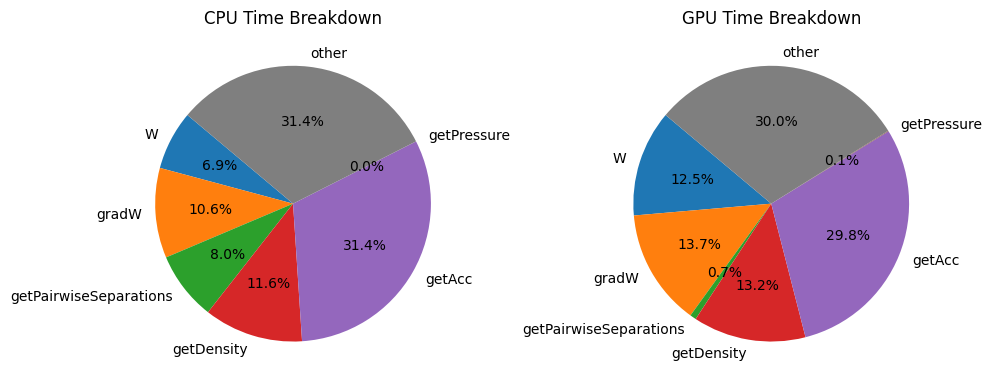

In [7]:
# clear old timings
for k in time_data_cpu:
    time_data_cpu[k] = 0
for k in time_data_gpu:
    time_data_gpu[k] = 0

# run profiling once
N_profile = 2000
simulate_cpu_profile(N_profile)
simulate_gpu_profile(N_profile)

def as_percent(d):
    total = sum(d.values())
    if total == 0:
        return {k:0 for k in d}
    return {k: 100*(v/total) for k,v in d.items()}

cpu_p = as_percent(time_data_cpu)
gpu_p = as_percent(time_data_gpu)

def show_aligned_pies(cpu_p, gpu_p):
    labels = ['W', 'gradW', 'getPairwiseSeparations', 'getDensity', 'getAcc', 'getPressure', 'other']

    color_map = {
        'W': 'tab:blue',
        'gradW': 'tab:orange',
        'getPairwiseSeparations': 'tab:green',
        'getDensity': 'tab:red',
        'getAcc': 'tab:purple',
        'getPressure': 'tab:brown',
        'other': 'tab:gray'
    }

    # map the CPU & GPU percentages to these labels in the same order
    cpu_sizes = [cpu_p[lbl] for lbl in labels]
    gpu_sizes = [gpu_p[lbl] for lbl in labels]

    # figure out the corresponding colors in that order
    colors = [color_map[lbl] for lbl in labels]

    fig, axs = plt.subplots(1, 2, figsize=(10,5))

    # CPU side
    axs[0].pie(cpu_sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    axs[0].set_title('CPU Time Breakdown')

    # GPU side
    axs[1].pie(gpu_sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    axs[1].set_title('GPU Time Breakdown')

    plt.tight_layout()
    plt.savefig("time_breakdown.png")
    plt.show()

show_aligned_pies(cpu_p, gpu_p)